In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = ALL, 1 = WARNING, 2 = ERROR, 3 = FATAL

# Global params

In [2]:
accepted_categories = ["dress", "high_heel", "handbag", "skirt", "outerwear", "boot"]
label2id = {
    "dress": 0,
    "high_heel": 1, 
    "handbag": 2,
    "skirt": 3, 
    "outerwear": 4, 
    "boot": 5
    
}
id2label = {
    0: "dress",
    1: "high_heel", 
    2: "handbag",
    3: "skirt", 
    4: "outerwear", 
    5: "boot"
}

RANDOM_STATE = 12345

# functions

In [20]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_save_metrics(model, val_ds, id2label, output_folder):
    """
    Evaluates accuracy, top-2, top-3 accuracy, precision, recall, and F1-score.
    Prints the results and saves them to an Excel file.

    Parameters:
    - model: Trained Keras model
    - val_ds: Validation tf.data.Dataset (batched)
    - id2label: Dictionary mapping label IDs to class names
    - output_folder: Folder path to save the Excel file
    """
    y_true = []
    y_pred = []
    y_pred_probs = []

    # Collect predictions
    for images, labels in val_ds:
        probs = model.predict(images, verbose=0)
        preds = tf.argmax(probs, axis=1).numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Top-k accuracy
    acc = accuracy_score(y_true, y_pred)
    top_2_acc = tf.keras.metrics.top_k_categorical_accuracy(
        tf.one_hot(y_true, depth=len(id2label)), y_pred_probs, k=2
    ).numpy().mean()

    top_3_acc = tf.keras.metrics.top_k_categorical_accuracy(
        tf.one_hot(y_true, depth=len(id2label)), y_pred_probs, k=3
    ).numpy().mean()

    # Class-wise metrics
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Print summary
    print(f"\n✅ Accuracy:     {acc:.4f}")
    print(f"🎯 Top-2 Acc:    {top_2_acc:.4f}")
    print(f"🎯 Top-3 Acc:    {top_3_acc:.4f}")
    print("\n📊 Per-class metrics:\n")

    rows = []
    for idx, class_name in id2label.items():
        row = {
            "class_id": idx,
            "class_name": class_name,
            "precision": precision[idx],
            "recall": recall[idx],
            "f1_score": f1[idx]
        }
        print(f"{class_name:15}  Precision: {precision[idx]:.4f}  Recall: {recall[idx]:.4f}  F1: {f1[idx]:.4f}")
        rows.append(row)

    # Save to Excel
    df_metrics = pd.DataFrame(rows)
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, "classification_report.xlsx")
    df_metrics.to_excel(output_path, index=False)
    print(f"\n📁 Report saved to: {output_path}")


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images_per_category(df, image_column='path', category_column='global_category', max_per_row=4):
    """
    Plot one random image per category from the dataframe.

    Parameters:
    - df: pandas.DataFrame with image paths and categories.
    - image_column: str, column name with image file paths.
    - category_column: str, column name with image categories.
    - max_per_row: int, number of images per row in the plot grid.
    """
    categories = df[category_column].unique()
    sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)

    num_categories = len(categories)
    num_cols = min(max_per_row, num_categories)
    num_rows = (num_categories + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = axes.flatten() if num_categories > 1 else [axes]

    for ax, (_, row) in zip(axes, sampled_rows.iterrows()):
        try:
            image = Image.open(row[image_column])
            ax.imshow(image)
            ax.set_title(f"{row[category_column]}")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, "Error loading image", ha='center')
            ax.set_title(row[category_column])
            ax.axis('off')
            print(f"Failed to load image at {row[image_column]}: {e}")

    # Hide unused subplots
    for ax in axes[len(sampled_rows):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd

def balance_dataframe_by_class(df, category_column='global_category', samples_per_class=100, random_state=42):
    """
    Returns a balanced dataframe with at most `samples_per_class` samples per category.
    If a category has fewer than the desired amount, all its samples are included.

    Parameters:
    - df (pd.DataFrame): Original DataFrame with category information.
    - category_column (str): Column name to balance by (e.g., 'global_category').
    - samples_per_class (int): Target number of samples per class.
    - random_state (int): Seed for reproducible sampling.

    Returns:
    - pd.DataFrame: Balanced DataFrame.
    """
    balanced_dfs = []

    for category, group in df.groupby(category_column):
        if len(group) <= samples_per_class:
            balanced_dfs.append(group)
        else:
            balanced_dfs.append(group.sample(n=samples_per_class, random_state=random_state))

    balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_df


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_top3_predictions(model, val_ds, id2label, rows=3, cols=8):
    """
    Muestra imágenes con las Top-3 predicciones de un modelo, coloreando en verde
    si la etiqueta verdadera está entre ellas, y rojo en caso contrario.

    Parameters:
    - model: modelo Keras o TensorFlow.
    - val_ds: dataset iterable (como tf.data.Dataset).
    - id2label: diccionario {id: nombre_clase}.
    - rows: número de filas a mostrar.
    - cols: número de columnas a mostrar.
    """
    val_images, val_labels = next(iter(val_ds))
    pred_probs = model.predict(val_images)
    
    top3_pred_indices = tf.math.top_k(pred_probs, k=3).indices.numpy()

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    fig.suptitle("Top-3 Predicciones del modelo", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= len(val_images):
            break

        image = val_images[i].numpy()
        true_label = int(val_labels[i].numpy())
        top3_labels = top3_pred_indices[i]

        top3_names = [id2label[idx] for idx in top3_labels]
        pred_text = "\n".join([f"{j+1}: {name}" for j, name in enumerate(top3_names)])

        color = "green" if true_label in top3_labels else "red"

        ax.imshow(image)
        ax.set_title(f"{pred_text}\nT: {id2label[true_label]}", color=color, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


2025-05-18 20:17:16.527021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747592236.540075   23090 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747592236.544241   23090 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747592236.556761   23090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747592236.556773   23090 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747592236.556775   23090 computation_placer.cc:177] computation placer alr

# Loading dataframes

In [6]:
import pandas as pd

train_dataframe = balance_dataframe_by_class(pd.read_csv("conf/train.csv"), samples_per_class=600, random_state=RANDOM_STATE)
validation_dataframe = balance_dataframe_by_class(pd.read_csv("conf/validation.csv"), samples_per_class=100, random_state=RANDOM_STATE)

/tmp/ipykernel_23090/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


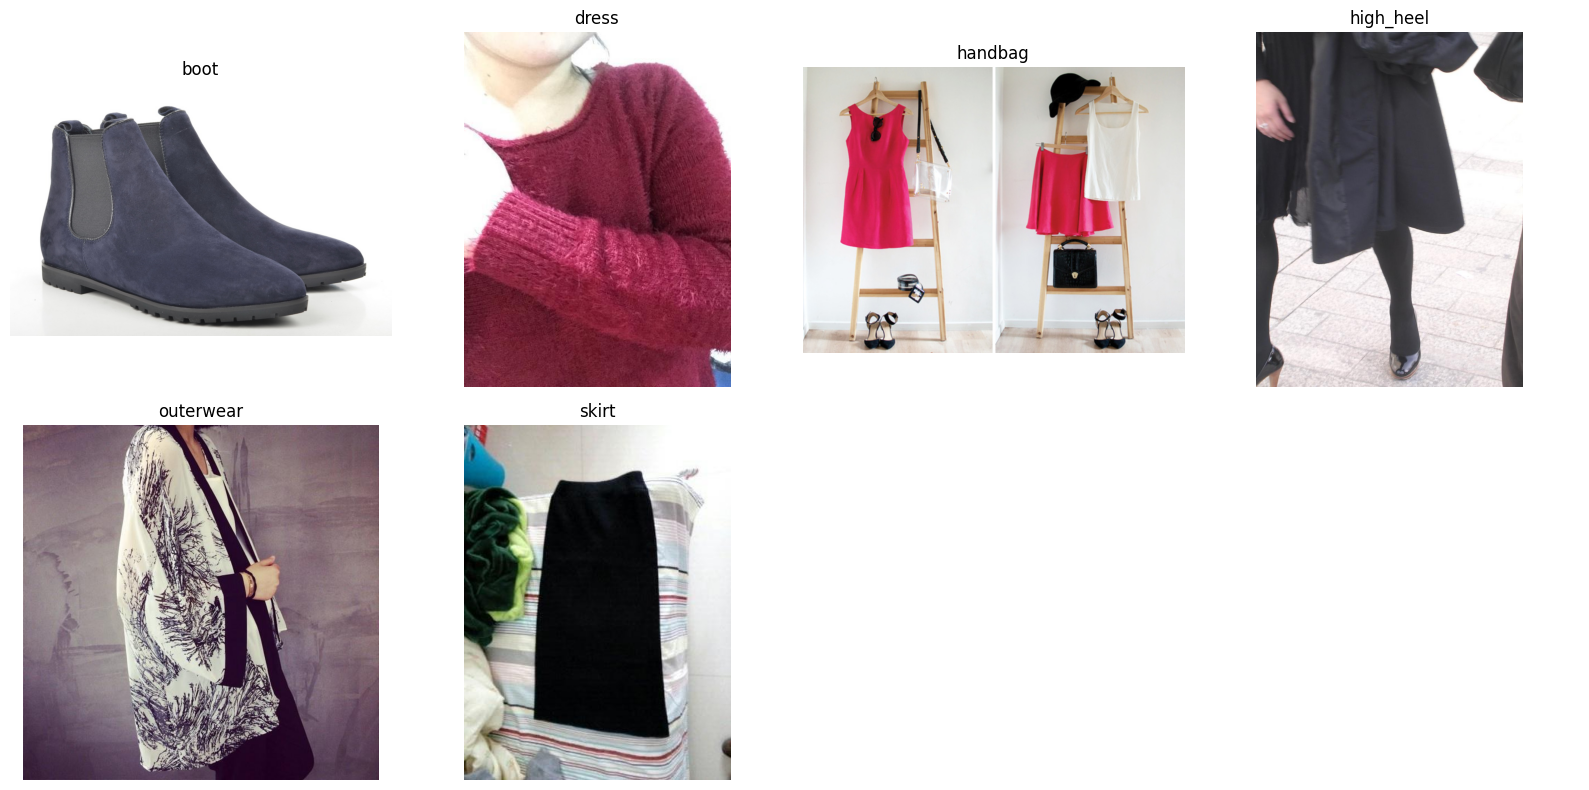

In [7]:
plot_random_images_per_category(train_dataframe)

/tmp/ipykernel_23090/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


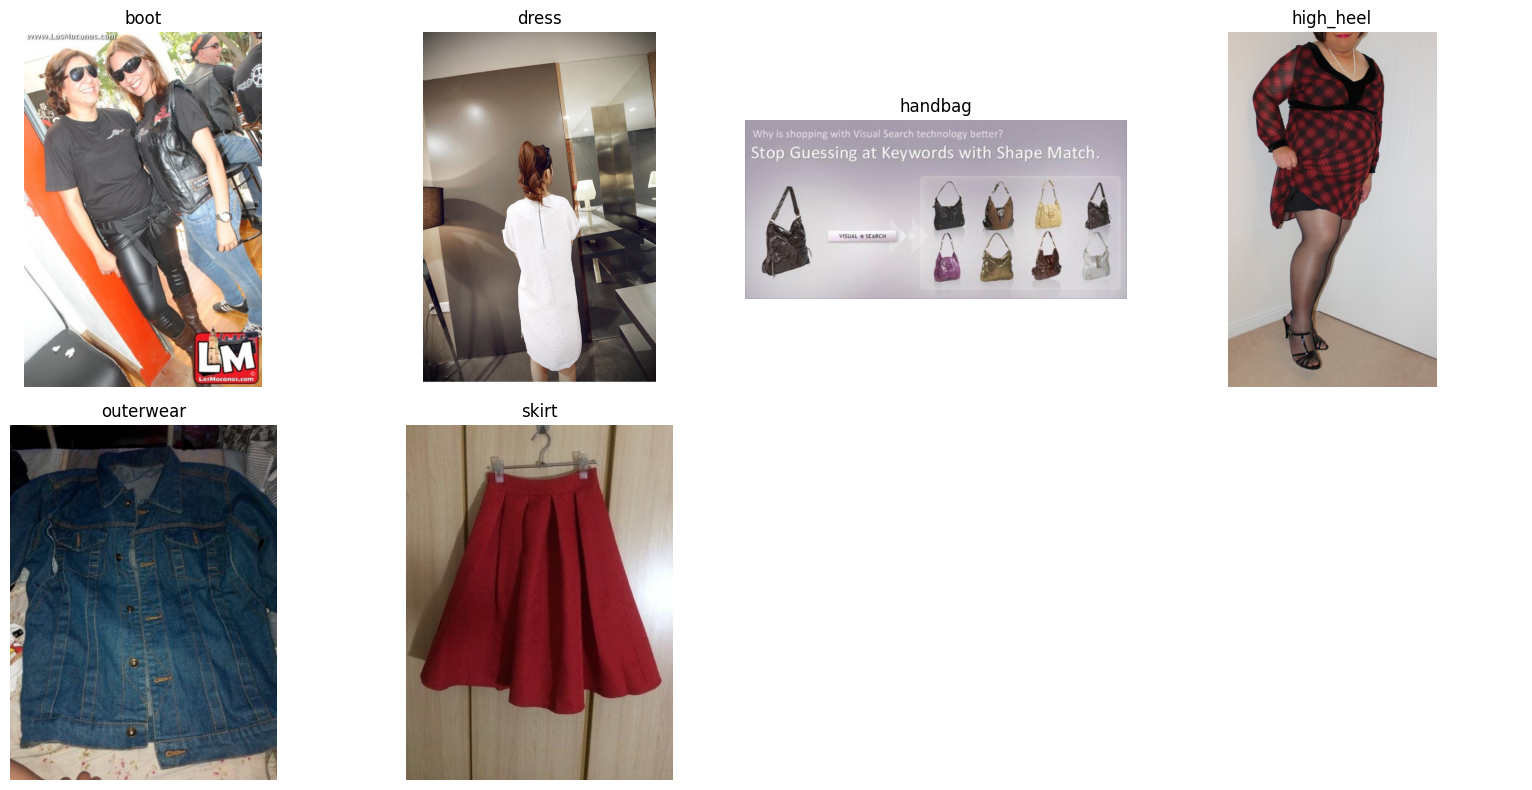

In [8]:
plot_random_images_per_category(validation_dataframe)

In [9]:
train_dataframe.groupby("global_category").size()

global_category
boot         400
dress        600
handbag      400
high_heel    400
outerwear    600
skirt        600
dtype: int64

In [10]:
validation_dataframe.groupby("label_id").size()

label_id
0    100
1    100
2    100
3    100
4    100
5    100
dtype: int64

In [11]:
train_dataframe.head(3)

,path,global_category,label_id
0,../custom_dataset/train/Labeled/Boot/ad595795f...,boot,5
1,../custom_dataset/train/Labeled/Boot/b093b5711...,boot,5
2,../custom_dataset/train/Labeled/Boot/2fb6778de...,boot,5


# General process

# pre-processing

In [21]:
import tensorflow as tf

IMG_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

train_ds = prepare_dataset(train_dataframe)
val_ds = prepare_dataset(validation_dataframe, shuffle=True)

# Training

In [22]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

## Efficient

In [23]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Custom sparse top-k accuracy metric
def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

# Define top-2 and top-3 metrics
top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)
top_3_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

# Load base MobileNet with ImageNet weights and without top
base_model = MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.2)(x)
output = Dense(len(accepted_categories), activation="softmax")(x)

# Final model
model_mobilenet = Model(inputs=base_model.input, outputs=output)

# Freeze all layers initially
for layer in base_model.layers:
    layer.trainable = False

# Unfreeze last 18 layers
for layer in base_model.layers[-9:]:
    layer.trainable = True

# Compile model
model_mobilenet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", top_2_accuracy, top_3_accuracy]
)


In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.callbacks import TensorBoard
import datetime


checkpoint_cb = ModelCheckpoint(
    filepath='models/model_mobilenet_tl/best_model.h5',             # O .keras para el nuevo formato
    monitor='val_accuracy',               # Métrica que decides monitorear
    save_best_only=True,                  # Guarda solo el mejor modelo
    mode='max',                           # Porque estás maximizando
    verbose=1
)

log_dir = "logs/fit/model_mobilenet_tl/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # Si quieres histogramas de activaciones
    write_graph=True,            # Guarda el grafo del modelo
    write_images=True            # Guarda imágenes de pesos y outputs (opcional)
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [25]:
history_efficient = model_mobilenet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop_cb,  checkpoint_cb, tensorboard_cb]
)

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

  config_arr = [serialize_keras_object(x) for x in obj]
/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_3_accuracy

Epoch 1/500


I0000 00:00:1747592594.764560   23172 service.cc:152] XLA service 0x7f7e30129bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747592594.764593   23172 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1747592595.223181   23172 cuda_dnn.cc:529] Loaded cuDNN version 90300


      9/Unknown 9s 14ms/step - accuracy: 0.2440 - lambda: 0.4143 - lambda_1: 0.5785 - loss: 2.2403

I0000 00:00:1747592599.494656   23172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     94/Unknown 14s 53ms/step - accuracy: 0.4673 - lambda: 0.6594 - lambda_1: 0.7821 - loss: 1.4840

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.45833, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 120ms/step - accuracy: 0.4685 - lambda: 0.6606 - lambda_1: 0.7830 - loss: 1.4804 - val_accuracy: 0.4583 - val_lambda: 0.7133 - val_lambda_1: 0.8633 - val_loss: 1.7059
Epoch 2/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7835 - lambda: 0.9249 - lambda_1: 0.9700 - loss: 0.5921
Epoch 2: val_accuracy improved from 0.45833 to 0.67333, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.7836 - lambda: 0.9250 - lambda_1: 0.9700 - loss: 0.5917 - val_accuracy: 0.6733 - val_lambda: 0.8583 - val_lambda_1: 0.9233 - val_loss: 0.9329
Epoch 3/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8850 - lambda: 0.9801 - lambda_1: 0.9948 - loss: 0.3508
Epoch 3: val_accuracy improved from 0.67333 to 0.70500, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8849 - lambda: 0.9799 - lambda_1: 0.9948 - loss: 0.3513 - val_accuracy: 0.7050 - val_lambda: 0.8867 - val_lambda_1: 0.9533 - val_loss: 0.8215
Epoch 4/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9199 - lambda: 0.9793 - lambda_1: 0.9978 - loss: 0.2691
Epoch 4: val_accuracy improved from 0.70500 to 0.71167, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9197 - lambda: 0.9794 - lambda_1: 0.9978 - loss: 0.2692 - val_accuracy: 0.7117 - val_lambda: 0.9017 - val_lambda_1: 0.9550 - val_loss: 0.7760
Epoch 5/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9485 - lambda: 0.9978 - lambda_1: 0.9997 - loss: 0.1882
Epoch 5: val_accuracy improved from 0.71167 to 0.73500, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9484 - lambda: 0.9977 - lambda_1: 0.9997 - loss: 0.1887 - val_accuracy: 0.7350 - val_lambda: 0.9133 - val_lambda_1: 0.9600 - val_loss: 0.7774
Epoch 6/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9650 - lambda: 0.9955 - lambda_1: 0.9992 - loss: 0.1611
Epoch 6: val_accuracy did not improve from 0.73500
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9648 - lambda: 0.9955 - lambda_1: 0.9991 - loss: 0.1612 - val_accuracy: 0.7167 - val_lambda: 0.9000 - val_lambda_1: 0.9533 - val_loss: 0.7989
Epoch 7/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9828 - lambda: 0.9991 - lambda_1: 1.0000 - loss: 0.1195
Epoch 7: val_accuracy did not improve from 0.73500
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9827 - lambda: 0.9991 - lambda_1: 1.0000 - loss: 0.1195 - val_accuracy: 0.7350 - val_lambda: 0.8950 - val_lambda_1: 0.9450 - val_loss: 0.8280
Epoch 8/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9855 - lambda: 1.0000 - lambda_1: 1.0000 - loss: 0.0913 - val_accuracy: 0.7450 - val_lambda: 0.8967 - val_lambda_1: 0.9567 - val_loss: 0.8005
Epoch 9/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9891 - lambda: 0.9992 - lambda_1: 1.0000 - loss: 0.0809
Epoch 9: val_accuracy improved from 0.74500 to 0.75500, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9891 - lambda: 0.9992 - lambda_1: 1.0000 - loss: 0.0810 - val_accuracy: 0.7550 - val_lambda: 0.8983 - val_lambda_1: 0.9567 - val_loss: 0.7519
Epoch 10/500
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9850 - lambda: 0.9993 - lambda_1: 1.0000 - loss: 0.0792
Epoch 10: val_accuracy did not improve from 0.75500
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9850 - lambda: 0.9993 - lambda_1: 1.0000 - loss: 0.0789 - val_accuracy: 0.7517 - val_lambda: 0.9300 - val_lambda_1: 0.9633 - val_loss: 0.7423
Epoch 11/500
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9925 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0591
Epoch 11: val_accuracy improved from 0.75500 to 0.76333, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9924 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0591 - val_accuracy: 0.7633 - val_lambda: 0.9117 - val_lambda_1: 0.9567 - val_loss: 0.7534
Epoch 12/500
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9888 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0569
Epoch 12: val_accuracy did not improve from 0.76333
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9888 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0571 - val_accuracy: 0.7533 - val_lambda: 0.9050 - val_lambda_1: 0.9583 - val_loss: 0.7920
Epoch 13/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9924 - lambda: 0.9997 - lambda_1: 1.0000 - loss: 0.0509
Epoch 13: val_accuracy improved from 0.76333 to 0.76500, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9924 - lambda: 0.9997 - lambda_1: 1.0000 - loss: 0.0509 - val_accuracy: 0.7650 - val_lambda: 0.9183 - val_lambda_1: 0.9683 - val_loss: 0.7649
Epoch 14/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9929 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0407
Epoch 14: val_accuracy did not improve from 0.76500
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9928 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0408 - val_accuracy: 0.7633 - val_lambda: 0.9117 - val_lambda_1: 0.9583 - val_loss: 0.7839
Epoch 15/500
92/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9895 - lambda: 0.9983 - lambda_1: 1.0000 - loss: 0.0454
Epoch 15: val_accuracy improved from 0.76500 to 0.76667, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.9896 - lambda: 0.9983 - lambda_1: 1.0000 - loss: 0.0453 - val_accuracy: 0.7667 - val_lambda: 0.9183 - val_lambda_1: 0.9650 - val_loss: 0.7795
Epoch 16/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9899 - lambda: 0.9994 - lambda_1: 1.0000 - loss: 0.0418
Epoch 16: val_accuracy did not improve from 0.76667
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9899 - lambda: 0.9994 - lambda_1: 1.0000 - loss: 0.0419 - val_accuracy: 0.7667 - val_lambda: 0.9150 - val_lambda_1: 0.9633 - val_loss: 0.7611
Epoch 17/500
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9938 - lambda: 0.9996 - lambda_1: 1.0000 - loss: 0.0359
Epoch 17: val_accuracy improved from 0.76667 to 0.76833, saving model to models/model_mobilenet_tl/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9936 - lambda: 0.9996 - lambda_1: 1.0000 - loss: 0.0363 - val_accuracy: 0.7683 - val_lambda: 0.9250 - val_lambda_1: 0.9700 - val_loss: 0.7965
Epoch 18/500
90/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9926 - lambda: 1.0000 - lambda_1: 1.0000 - loss: 0.0366
Epoch 18: val_accuracy did not improve from 0.76833
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9925 - lambda: 1.0000 - lambda_1: 1.0000 - loss: 0.0367 - val_accuracy: 0.7683 - val_lambda: 0.9100 - val_lambda_1: 0.9617 - val_loss: 0.7869
Epoch 19/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9931 - lambda: 0.9993 - lambda_1: 1.0000 - loss: 0.0348
Epoch 19: val_accuracy did not improve from 0.76833
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9930 - lambda: 0.9993 - lambda_1: 1.0000 - loss: 0.0349 - val_accuracy: 0.7517 - val_lambda: 0.9050 - val_lambda_1: 0.9550 - val_loss: 0.8206
Epoch 20/500
91/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9905 - lambda: 0.9994 - lambda_1: 1.0000 - loss: 0.0335 - val_accuracy: 0.7800 - val_lambda: 0.9250 - val_lambda_1: 0.9617 - val_loss: 0.7857
Epoch 23/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9919 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0318
Epoch 23: val_accuracy did not improve from 0.78000
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.9919 - lambda: 0.9999 - lambda_1: 1.0000 - loss: 0.0319 - val_accuracy: 0.7350 - val_lambda: 0.8900 - val_lambda_1: 0.9467 - val_loss: 0.9409
Epoch 24/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9927 - lambda: 0.9997 - lambda_1: 1.0000 - loss: 0.0272
Epoch 24: val_accuracy did not improve from 0.78000
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9927 - lambda: 0.9997 - lambda_1: 1.0000 - loss: 0.0273 - val_accuracy: 0.7650 - val_lambda: 0.9317 - val_lambda_1: 0.9683 - val_loss: 0.7843
Epoch 25/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accurac

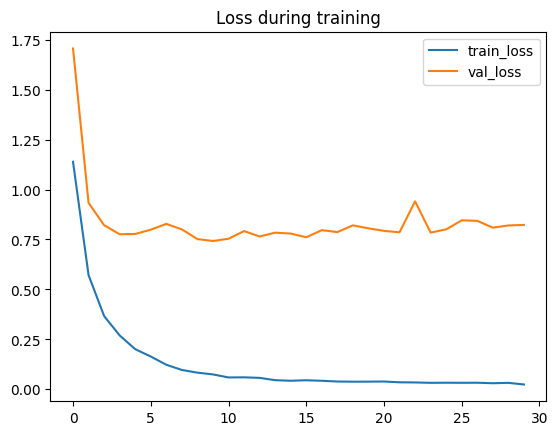

In [26]:
import matplotlib.pyplot as plt

plt.title("Loss during training")
plt.plot(history_efficient.history['loss'], label='train_loss')
plt.plot(history_efficient.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


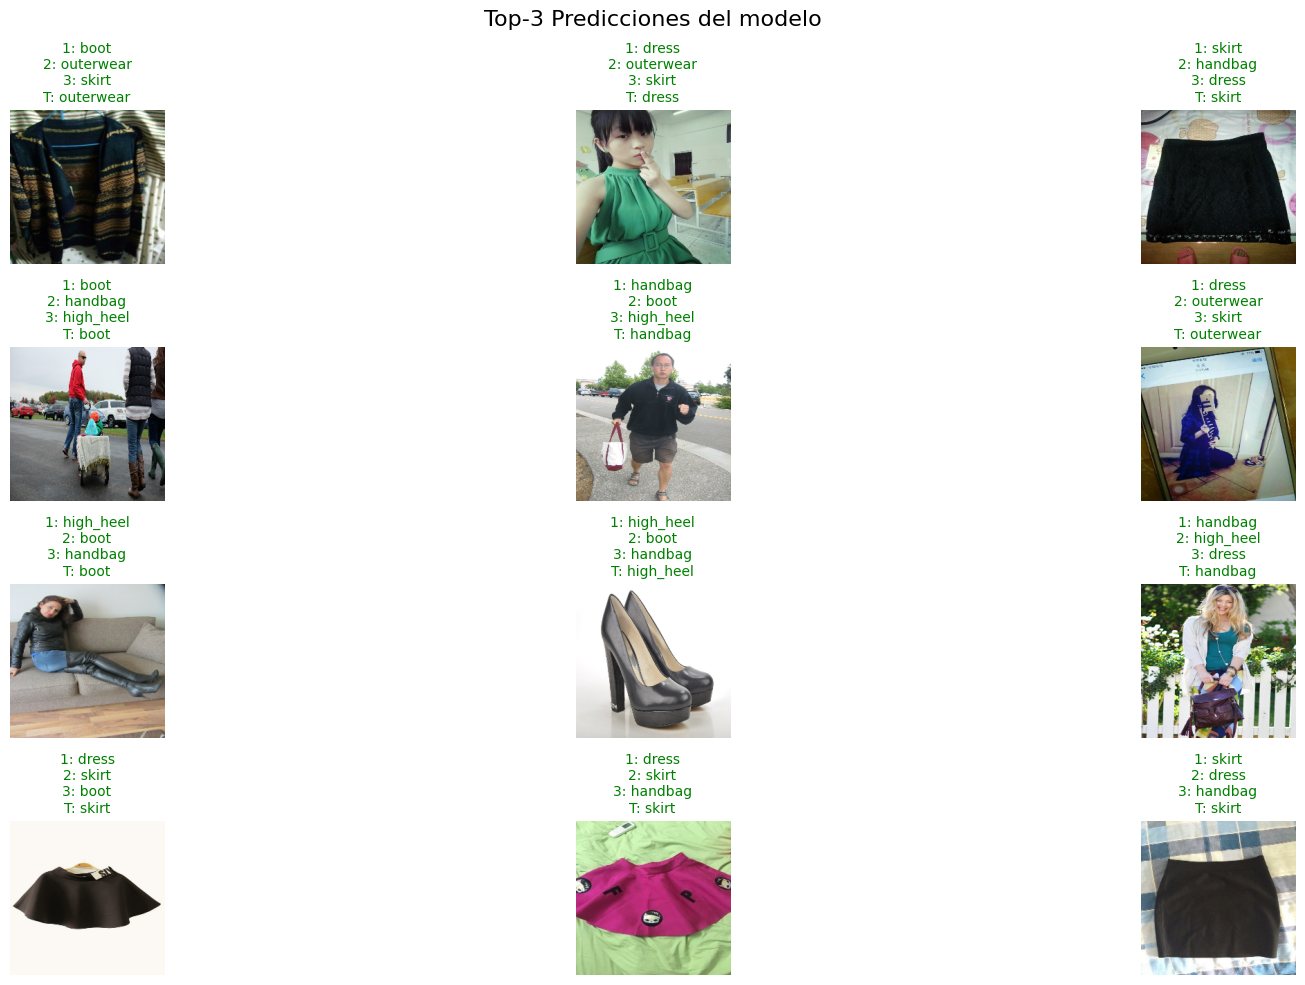

In [28]:
plot_top3_predictions(model_mobilenet, val_ds, id2label, rows=4, cols=3)

In [29]:
evaluate_and_save_metrics(model_mobilenet, val_ds, id2label, output_folder="./models/model_mobilenet_tl/")


✅ Accuracy:     0.7517
🎯 Top-2 Acc:    0.9300
🎯 Top-3 Acc:    0.9633

📊 Per-class metrics:

dress            Precision: 0.7451  Recall: 0.7600  F1: 0.7525
high_heel        Precision: 0.7037  Recall: 0.7600  F1: 0.7308
handbag          Precision: 0.7431  Recall: 0.8100  F1: 0.7751
skirt            Precision: 0.7679  Recall: 0.8600  F1: 0.8113
outerwear        Precision: 0.8750  Recall: 0.7000  F1: 0.7778
boot             Precision: 0.6966  Recall: 0.6200  F1: 0.6561

📁 Report saved to: ./models/model_mobilenet_tl/classification_report.xlsx
